
**Model:** Hierarchical Ensemble (ExtraTrees + XGBoost + LightGBM)  
**Features:** Time + FFT + Jerk + Entropy + Cross-correlation + Wavelet  
**Strategy:** 2-Level Classification + Data Augmentation + Stacking

In [1]:
# ============================================================
# CELL 0: CLONE REPOSITORY (Chạy 1 lần duy nhất)
# ============================================================
import os

# Clone repo nếu chưa có
REPO_URL = "https://github.com/Khanghcmut/ABC_challenge_2026_test.git"
REPO_NAME = "ABC_challenge_2026_test"

if not os.path.exists(REPO_NAME):
    print("📥 Cloning repository...")
    !git clone {REPO_URL}
    print("✅ Repository cloned successfully!")
else:
    print(f"✅ Repository '{REPO_NAME}' already exists!")

# Chuyển vào thư mục repo
os.chdir(REPO_NAME)
print(f"📂 Current directory: {os.getcwd()}")

📥 Cloning repository...
Cloning into 'ABC_challenge_2026_test'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 92 (delta 0), reused 0 (delta 0), pack-reused 88 (from 2)
Receiving objects: 100% (92/92), 110.49 MiB | 15.34 MiB/s, done.
remote: Total 92 (delta 0), reused 0 (delta 0), pack-reused 88 (from 2)
Receiving objects: 100% (92/92), 110.49 MiB | 15.34 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Resolving deltas: 100% (18/18), done.
Updating files: 100% (52/52), done.
✅ Repository cloned successfully!
📂 Current directory: /content/ABC_challenge_2026_test
Updating files: 100% (52/52), done.
✅ Repository cloned successfully!
📂 Current directory: /content/ABC_challenge_2026_test


In [2]:
# ============================================================
# CELL 1: IMPORTS & SETUP
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier, StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Gradient Boosting
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Imbalanced Learning
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek

# Signal Processing
from numpy.fft import fft
from scipy.stats import entropy, skew, kurtosis
from scipy.signal import find_peaks
import pywt  # Wavelet

# Config
WINDOW_SIZE = 50
OVERLAP = 25  # Tăng overlap để có nhiều samples hơn
N_FOLDS = 5
RANDOM_STATE = 42

# Hierarchical Classification Mapping
CATEGORY_MAP = {
    'jogging': 'dynamic', 'jogging (butt-kicks)': 'dynamic', 
    'jogging (rotating arms)': 'dynamic', 'jogging (sidesteps)': 'dynamic',
    'jogging (skipping)': 'dynamic', 'burpees': 'dynamic',
    'push-ups': 'upper_static', 'push-ups (complex)': 'upper_static',
    'bench-dips': 'upper_static',
    'sit-ups': 'core_static', 'sit-ups (complex)': 'core_static',
    'lunges': 'lower_body', 'lunges (complex)': 'lower_body',
    'stretching (hamstrings)': 'stretching', 'stretching (lumbar rotation)': 'stretching',
    'stretching (lunging)': 'stretching', 'stretching (shoulders)': 'stretching',
    'stretching (triceps)': 'stretching'
}

print("✅ All libraries imported successfully!")
print(f"📊 Config: Window={WINDOW_SIZE}, Overlap={OVERLAP}%, Hierarchical=True")

✅ All libraries imported successfully!
📊 Config: Window=50, Overlap=25%, Hierarchical=True


In [3]:
# ============================================================
# CELL 2: LOAD DATA
# ============================================================
import glob

# Đường dẫn đến thư mục dữ liệu (giống notebook cũ)
DATA_DIR = "Inertial/WEAR/Processed_data_shrink"

# Lấy danh sách các file train (1_*) và test (2_*)
train_files = sorted(glob.glob(os.path.join(DATA_DIR, "1_*.csv")))
test_files = sorted(glob.glob(os.path.join(DATA_DIR, "2_*.csv")))

# Hàm load và gộp nhiều file CSV
def load_multiple_csv(file_list):
    dfs = []
    for filepath in file_list:
        df = pd.read_csv(filepath)
        df['source_file'] = os.path.basename(filepath)
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

# Load dữ liệu
df_train = load_multiple_csv(train_files)
df_test = load_multiple_csv(test_files)

print(f"📂 Train files: {len(train_files)}, Test files: {len(test_files)}")
print(f"📊 Train shape: {df_train.shape}, Test shape: {df_test.shape}")
print(f"📋 Columns: {list(df_train.columns)}")

📂 Train files: 4, Test files: 4
📊 Train shape: (284438, 8), Test shape: (284438, 8)
📋 Columns: ['leg_acc_x', 'leg_acc_y', 'leg_acc_z', 'arm_acc_x', 'arm_acc_y', 'arm_acc_z', 'label', 'source_file']


In [4]:
# ============================================================
# CELL 3: QUICK EDA - DATA OVERVIEW
# ============================================================
acc_columns = ['leg_acc_x', 'leg_acc_y', 'leg_acc_z', 'arm_acc_x', 'arm_acc_y', 'arm_acc_z']

# Missing values
missing_train = df_train['label'].isna().sum()
missing_test = df_test['label'].isna().sum()

print("="*60)
print("📊 DATA OVERVIEW")
print("="*60)
print(f"Train samples: {len(df_train):,}")
print(f"Test samples: {len(df_test):,}")
print(f"Missing labels - Train: {missing_train:,} ({missing_train/len(df_train)*100:.1f}%)")
print(f"Missing labels - Test: {missing_test:,} ({missing_test/len(df_test)*100:.1f}%)")
print(f"\n📈 Accelerometer Statistics:")
print(df_train[acc_columns].describe().round(3))

📊 DATA OVERVIEW
Train samples: 284,438
Test samples: 284,438
Missing labels - Train: 93,263 (32.8%)
Missing labels - Test: 93,263 (32.8%)

📈 Accelerometer Statistics:
        leg_acc_x   leg_acc_y   leg_acc_z   arm_acc_x   arm_acc_y   arm_acc_z
count  284438.000  284438.000  284438.000  284438.000  284438.000  284438.000
mean        0.799       0.021       0.178      -0.235       0.331      -0.214
std         0.664       0.757       0.449       0.950       0.685       0.507
min        -3.707      -7.566      -5.352      -7.993      -3.699      -4.935
25%         0.425      -0.383       0.009      -0.890      -0.036      -0.522
50%         0.912      -0.048       0.147      -0.215       0.291      -0.197
75%         0.992       0.407       0.349       0.491       0.608       0.072
max         7.809       7.498       4.529       7.992       7.756       4.775


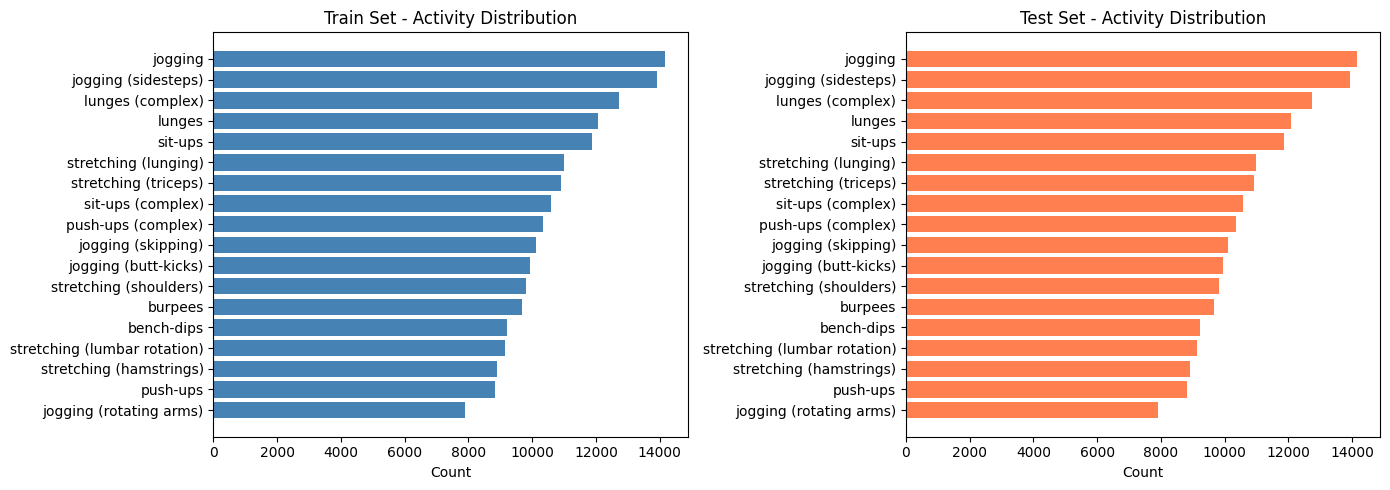


🏷️ Unique activities: 18 classes


In [5]:
# ============================================================
# CELL 4: EDA - ACTIVITY DISTRIBUTION
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train distribution
train_counts = df_train['label'].value_counts()
axes[0].barh(train_counts.index.astype(str), train_counts.values, color='steelblue')
axes[0].set_xlabel('Count')
axes[0].set_title('Train Set - Activity Distribution')
axes[0].invert_yaxis()

# Test distribution  
test_counts = df_test['label'].value_counts()
axes[1].barh(test_counts.index.astype(str), test_counts.values, color='coral')
axes[1].set_xlabel('Count')
axes[1].set_title('Test Set - Activity Distribution')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print(f"\n🏷️ Unique activities: {df_train['label'].nunique()} classes")

In [6]:
# ============================================================
# CELL 5: PREPROCESSING - CLEAN & ENCODE
# ============================================================
# Remove missing labels
df_train_clean = df_train.dropna(subset=['label']).reset_index(drop=True)
df_test_clean = df_test.dropna(subset=['label']).reset_index(drop=True)

print(f"✅ After removing NaN labels:")
print(f"   Train: {len(df_train):,} → {len(df_train_clean):,}")
print(f"   Test: {len(df_test):,} → {len(df_test_clean):,}")

# Label encoding
unique_labels = sorted(df_train_clean['label'].unique())
encode_label = {label: idx for idx, label in enumerate(unique_labels)}
decode_label = {idx: label for label, idx in encode_label.items()}

df_train_clean['label_encoded'] = df_train_clean['label'].map(encode_label)
df_test_clean['label_encoded'] = df_test_clean['label'].map(encode_label)

print(f"\n🏷️ Label Encoding ({len(encode_label)} classes):")
for label, code in encode_label.items():
    print(f"   {code}: {label}")

✅ After removing NaN labels:
   Train: 284,438 → 191,175
   Test: 284,438 → 191,175

🏷️ Label Encoding (18 classes):
   0: bench-dips
   1: burpees
   2: jogging
   3: jogging (butt-kicks)
   4: jogging (rotating arms)
   5: jogging (sidesteps)
   6: jogging (skipping)
   7: lunges
   8: lunges (complex)
   9: push-ups
   10: push-ups (complex)
   11: sit-ups
   12: sit-ups (complex)
   13: stretching (hamstrings)
   14: stretching (lumbar rotation)
   15: stretching (lunging)
   16: stretching (shoulders)
   17: stretching (triceps)


In [7]:
# ============================================================
# CELL 6: ADVANCED FEATURE EXTRACTION (Time + FFT + Jerk + Entropy + Wavelet)
# ============================================================
def extract_time_features(window):
    """Extract time-domain features from a window"""
    features = {}
    for col in acc_columns:
        data = window[col].values
        prefix = col
        
        # Basic Statistical features
        features[f'{prefix}_mean'] = np.mean(data)
        features[f'{prefix}_std'] = np.std(data)
        features[f'{prefix}_min'] = np.min(data)
        features[f'{prefix}_max'] = np.max(data)
        features[f'{prefix}_range'] = np.ptp(data)
        features[f'{prefix}_median'] = np.median(data)
        features[f'{prefix}_iqr'] = np.percentile(data, 75) - np.percentile(data, 25)
        features[f'{prefix}_rms'] = np.sqrt(np.mean(data**2))
        
        # Advanced Statistical (Skewness, Kurtosis)
        features[f'{prefix}_skew'] = skew(data)
        features[f'{prefix}_kurtosis'] = kurtosis(data)
        
        # Signal Entropy - phân biệt random vs structured
        hist, _ = np.histogram(data, bins=10, density=True)
        hist = hist[hist > 0]
        features[f'{prefix}_entropy'] = entropy(hist)
        
        # Zero Crossing Rate - phân biệt repetitive motion
        zero_crossings = np.sum(np.diff(np.sign(data - np.mean(data))) != 0)
        features[f'{prefix}_zcr'] = zero_crossings / len(data)
        
        # Peak count - phân biệt cyclic motion
        peaks, _ = find_peaks(data, height=np.mean(data))
        features[f'{prefix}_peak_count'] = len(peaks) / len(data)
        
        # Jerk (derivative of acceleration) - phân biệt sudden vs smooth
        jerk = np.diff(data)
        features[f'{prefix}_jerk_mean'] = np.mean(np.abs(jerk))
        features[f'{prefix}_jerk_std'] = np.std(jerk)
        features[f'{prefix}_jerk_max'] = np.max(np.abs(jerk))
    
    # Cross-axis features - Magnitude
    leg_mag = np.sqrt(window['leg_acc_x']**2 + window['leg_acc_y']**2 + window['leg_acc_z']**2)
    arm_mag = np.sqrt(window['arm_acc_x']**2 + window['arm_acc_y']**2 + window['arm_acc_z']**2)
    
    features['leg_magnitude_mean'] = np.mean(leg_mag)
    features['leg_magnitude_std'] = np.std(leg_mag)
    features['arm_magnitude_mean'] = np.mean(arm_mag)
    features['arm_magnitude_std'] = np.std(arm_mag)
    
    # Arm-Leg Correlation - synchronized vs independent movement
    features['leg_arm_corr_x'] = np.corrcoef(window['leg_acc_x'], window['arm_acc_x'])[0,1]
    features['leg_arm_corr_y'] = np.corrcoef(window['leg_acc_y'], window['arm_acc_y'])[0,1]
    features['leg_arm_corr_z'] = np.corrcoef(window['leg_acc_z'], window['arm_acc_z'])[0,1]
    features['leg_arm_corr_mag'] = np.corrcoef(leg_mag, arm_mag)[0,1]
    
    # Handle NaN correlations
    for key in ['leg_arm_corr_x', 'leg_arm_corr_y', 'leg_arm_corr_z', 'leg_arm_corr_mag']:
        if np.isnan(features[key]):
            features[key] = 0
    
    # Ratio features - arm vs leg activity
    features['arm_leg_ratio'] = np.mean(arm_mag) / (np.mean(leg_mag) + 1e-6)
    
    return features

def extract_fft_features(window):
    """Extract FFT frequency-domain features"""
    features = {}
    for col in acc_columns:
        data = window[col].values
        fft_vals = np.abs(fft(data))
        fft_half = fft_vals[:len(fft_vals)//2]
        
        prefix = f'{col}_fft'
        features[f'{prefix}_mean'] = np.mean(fft_half)
        features[f'{prefix}_std'] = np.std(fft_half)
        features[f'{prefix}_max'] = np.max(fft_half)
        features[f'{prefix}_energy'] = np.sum(fft_half**2)
        
        # Dominant frequency
        if len(fft_half) > 0:
            features[f'{prefix}_dominant_freq'] = np.argmax(fft_half)
            freqs = np.arange(len(fft_half))
            if np.sum(fft_half) > 0:
                features[f'{prefix}_centroid'] = np.sum(freqs * fft_half) / np.sum(fft_half)
            else:
                features[f'{prefix}_centroid'] = 0
        
        # Band energies
        n = len(fft_half)
        if n >= 3:
            features[f'{prefix}_low_energy'] = np.sum(fft_half[:n//3]**2)
            features[f'{prefix}_mid_energy'] = np.sum(fft_half[n//3:2*n//3]**2)
            features[f'{prefix}_high_energy'] = np.sum(fft_half[2*n//3:]**2)
            # Spectral ratio
            total = features[f'{prefix}_energy'] + 1e-6
            features[f'{prefix}_low_ratio'] = features[f'{prefix}_low_energy'] / total
            features[f'{prefix}_high_ratio'] = features[f'{prefix}_high_energy'] / total
    
    return features

def extract_wavelet_features(window):
    """Extract Wavelet features - better for non-stationary signals"""
    features = {}
    for col in acc_columns:
        data = window[col].values
        # Discrete Wavelet Transform
        coeffs = pywt.wavedec(data, 'db4', level=3)
        
        for i, coeff in enumerate(coeffs):
            prefix = f'{col}_wavelet_L{i}'
            features[f'{prefix}_energy'] = np.sum(coeff**2)
            features[f'{prefix}_mean'] = np.mean(np.abs(coeff))
            features[f'{prefix}_std'] = np.std(coeff)
    
    return features

def extract_all_features(window):
    """Combine all feature types"""
    time_feats = extract_time_features(window)
    fft_feats = extract_fft_features(window)
    wavelet_feats = extract_wavelet_features(window)
    return {**time_feats, **fft_feats, **wavelet_feats}

print("✅ Advanced feature extraction defined")
print("   📊 Time features: ~100 (incl. jerk, entropy, zcr, correlation)")
print("   📊 FFT features: ~60")
print("   📊 Wavelet features: ~72")
print("   📊 Total: ~230+ features")

✅ Advanced feature extraction defined
   📊 Time features: ~100 (incl. jerk, entropy, zcr, correlation)
   📊 FFT features: ~60
   📊 Wavelet features: ~72
   📊 Total: ~230+ features


In [8]:
# ============================================================
# CELL 7: CREATE DATASET (OPTIMIZED - Fixed Version)
# ============================================================
from tqdm import tqdm

def create_dataset_v2_fast(df, window_size=WINDOW_SIZE, overlap=OVERLAP):
    """Create feature dataset - Sequential but optimized"""
    step = window_size - int(window_size * overlap / 100)
    if step < 1:
        step = 1
    
    # Pre-compute window starts
    starts = list(range(0, len(df) - window_size + 1, step))
    n_windows = len(starts)
    print(f"   📊 Total windows to process: {n_windows:,}")
    
    features_list = []
    labels_list = []
    categories_list = []
    
    # Sequential processing with progress bar (more stable)
    for start in tqdm(starts, desc="   Extracting features"):
        window = df.iloc[start:start + window_size]
        
        # Get majority label
        label = int(window['label_encoded'].mode().iloc[0])
        original_label = decode_label[label]
        category = CATEGORY_MAP.get(original_label, 'other')
        
        # Extract features
        all_feats = extract_all_features(window)
        features_list.append(all_feats)
        labels_list.append(label)
        categories_list.append(category)
    
    X = pd.DataFrame(features_list)
    y = np.array(labels_list)
    cats = np.array(categories_list)
    
    # Replace inf/nan with 0
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    return X, y, cats

# Create datasets
print(f"🔄 Creating dataset...")
print(f"   Window={WINDOW_SIZE}, Overlap={OVERLAP}%")

X_train, y_train, cats_train = create_dataset_v2_fast(df_train_clean)
X_test, y_test, cats_test = create_dataset_v2_fast(df_test_clean)

# Encode categories
cat_encoder = LabelEncoder()
y_cat_train = cat_encoder.fit_transform(cats_train)
y_cat_test = cat_encoder.transform(cats_test)

print(f"\n✅ Dataset created:")
print(f"   Train: {X_train.shape[0]} windows, {X_train.shape[1]} features")
print(f"   Test: {X_test.shape[0]} windows, {X_test.shape[1]} features")

🔄 Creating dataset...
   Window=50, Overlap=25%
   📊 Total windows to process: 5,030


   Extracting features: 100%|██████████| 5030/5030 [01:26<00:00, 58.47it/s]



   📊 Total windows to process: 5,030


   Extracting features: 100%|██████████| 5030/5030 [01:25<00:00, 58.80it/s]




✅ Dataset created:
   Train: 5030 windows, 243 features
   Test: 5030 windows, 243 features


In [9]:
# ============================================================
# CELL 7.5: MULTI-WINDOW SIZE EXPERIMENT
# ============================================================
# Thử nghiệm các window size khác nhau để tìm optimal
# Comment out nếu muốn dùng window size mặc định (50)

print("="*60)
print("🔬 MULTI-WINDOW SIZE EXPERIMENT")
print("="*60)

def quick_evaluate(X_tr, y_tr, X_te, y_te, window_name):
    """Quick evaluation với ExtraTrees (nhanh và ổn định)"""
    from sklearn.preprocessing import StandardScaler
    
    # Scale
    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_tr)
    X_te_scaled = scaler.transform(X_te)
    
    # Quick model
    model = ExtraTreesClassifier(
        n_estimators=100,
        max_depth=12,
        min_samples_split=10,
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    
    model.fit(X_tr_scaled, y_tr)
    train_acc = accuracy_score(y_tr, model.predict(X_tr_scaled))
    test_acc = accuracy_score(y_te, model.predict(X_te_scaled))
    gap = train_acc - test_acc
    
    return train_acc, test_acc, gap

# Test different window sizes
WINDOW_SIZES_TO_TEST = [50, 100, 150, 200]  # samples
OVERLAP_PERCENT = 50  # 50% overlap (tốt hơn 25%)

results = {}

for ws in WINDOW_SIZES_TO_TEST:
    print(f"\n{'='*40}")
    print(f"🔄 Testing Window Size = {ws} samples")
    print(f"{'='*40}")
    
    try:
        # Create dataset with this window size
        X_tr, y_tr, _ = create_dataset_v2_fast(df_train_clean, window_size=ws, overlap=OVERLAP_PERCENT)
        X_te, y_te, _ = create_dataset_v2_fast(df_test_clean, window_size=ws, overlap=OVERLAP_PERCENT)
        
        # Quick evaluate
        train_acc, test_acc, gap = quick_evaluate(X_tr, y_tr, X_te, y_te, f"ws_{ws}")
        
        results[ws] = {
            'train_acc': train_acc,
            'test_acc': test_acc,
            'gap': gap,
            'n_train': len(y_tr),
            'n_test': len(y_te)
        }
        
        print(f"   Train: {train_acc:.4f}, Test: {test_acc:.4f}, Gap: {gap:.4f}")
        print(f"   N_train: {len(y_tr):,}, N_test: {len(y_te):,}")
        
    except Exception as e:
        print(f"   ❌ Error: {e}")
        results[ws] = None

# Summary
print("\n" + "="*60)
print("📊 WINDOW SIZE COMPARISON SUMMARY")
print("="*60)
print(f"{'Window':<10} {'Train Acc':<12} {'Test Acc':<12} {'Gap':<10} {'N_Train':<10}")
print("-"*60)

best_ws = None
best_test_acc = 0

for ws, res in results.items():
    if res:
        print(f"{ws:<10} {res['train_acc']:<12.4f} {res['test_acc']:<12.4f} {res['gap']:<10.4f} {res['n_train']:<10}")
        if res['test_acc'] > best_test_acc:
            best_test_acc = res['test_acc']
            best_ws = ws

print("-"*60)
if best_ws:
    print(f"🏆 BEST Window Size: {best_ws} (Test Acc: {best_test_acc:.4f})")
    
    # Recommendation
    print("\n💡 RECOMMENDATION:")
    if best_ws != WINDOW_SIZE:
        print(f"   Consider changing WINDOW_SIZE from {WINDOW_SIZE} to {best_ws}")
        print(f"   This could improve test accuracy significantly!")
    else:
        print(f"   Current WINDOW_SIZE={WINDOW_SIZE} is optimal!")

# Lưu lại best window size để sử dụng
OPTIMAL_WINDOW_SIZE = best_ws if best_ws else WINDOW_SIZE
OPTIMAL_OVERLAP = OVERLAP_PERCENT

print(f"\n📌 Will use: WINDOW_SIZE={OPTIMAL_WINDOW_SIZE}, OVERLAP={OPTIMAL_OVERLAP}%")

🔬 MULTI-WINDOW SIZE EXPERIMENT

🔄 Testing Window Size = 50 samples
   📊 Total windows to process: 7,646


   Extracting features: 100%|██████████| 7646/7646 [02:10<00:00, 58.49it/s]



   📊 Total windows to process: 7,646


   Extracting features: 100%|██████████| 7646/7646 [02:10<00:00, 58.56it/s]



   Train: 0.9846, Test: 0.6364, Gap: 0.3482
   N_train: 7,646, N_test: 7,646

🔄 Testing Window Size = 100 samples
   📊 Total windows to process: 3,822


   Extracting features: 100%|██████████| 3822/3822 [01:05<00:00, 58.61it/s]



   📊 Total windows to process: 3,822


   Extracting features: 100%|██████████| 3822/3822 [01:05<00:00, 58.46it/s]



   Train: 0.9961, Test: 0.7467, Gap: 0.2493
   N_train: 3,822, N_test: 3,822

🔄 Testing Window Size = 150 samples
   📊 Total windows to process: 2,548


   Extracting features: 100%|██████████| 2548/2548 [00:43<00:00, 58.12it/s]


   📊 Total windows to process: 2,548


   Extracting features: 100%|██████████| 2548/2548 [00:43<00:00, 58.17it/s]


   Train: 0.9992, Test: 0.8042, Gap: 0.1951
   N_train: 2,548, N_test: 2,548

🔄 Testing Window Size = 200 samples
   📊 Total windows to process: 1,910


   Extracting features: 100%|██████████| 1910/1910 [00:33<00:00, 57.87it/s]



   📊 Total windows to process: 1,910


   Extracting features: 100%|██████████| 1910/1910 [00:32<00:00, 57.99it/s]



   Train: 1.0000, Test: 0.8288, Gap: 0.1712
   N_train: 1,910, N_test: 1,910

📊 WINDOW SIZE COMPARISON SUMMARY
Window     Train Acc    Test Acc     Gap        N_Train   
------------------------------------------------------------
50         0.9846       0.6364       0.3482     7646      
100        0.9961       0.7467       0.2493     3822      
150        0.9992       0.8042       0.1951     2548      
200        1.0000       0.8288       0.1712     1910      
------------------------------------------------------------
🏆 BEST Window Size: 200 (Test Acc: 0.8288)

💡 RECOMMENDATION:
   Consider changing WINDOW_SIZE from 50 to 200
   This could improve test accuracy significantly!

📌 Will use: WINDOW_SIZE=200, OVERLAP=50%


In [10]:
# ============================================================
# CELL 8: SIMPLIFIED PIPELINE (NO Feature Selection, NO SMOTE)
# ============================================================
# Mục tiêu: Đạt lại ~82% test accuracy như experiment

print("="*60)
print("🎯 SIMPLIFIED PIPELINE V2")
print("="*60)

# ============================================================
# STEP 1: Use OPTIMAL Window Size from experiment
# ============================================================
try:
    USE_WINDOW = OPTIMAL_WINDOW_SIZE
    USE_OVERLAP = OPTIMAL_OVERLAP
except NameError:
    USE_WINDOW = 200  # Default based on experiment results
    USE_OVERLAP = 50

print(f"\n📊 Configuration:")
print(f"   Window Size: {USE_WINDOW}")
print(f"   Overlap: {USE_OVERLAP}%")
print(f"   Feature Selection: ❌ DISABLED (keep all features)")
print(f"   SMOTE: ❌ DISABLED (use class_weight)")

# Recreate dataset with optimal window if needed
if 'OPTIMAL_WINDOW_SIZE' in dir() and OPTIMAL_WINDOW_SIZE != WINDOW_SIZE:
    print(f"\n🔄 Recreating dataset with Window={USE_WINDOW}, Overlap={USE_OVERLAP}%...")
    X_train, y_train, cats_train = create_dataset_v2_fast(df_train_clean, 
                                                           window_size=USE_WINDOW, 
                                                           overlap=USE_OVERLAP)
    X_test, y_test, cats_test = create_dataset_v2_fast(df_test_clean, 
                                                        window_size=USE_WINDOW, 
                                                        overlap=USE_OVERLAP)
    print(f"   ✅ Dataset: Train={X_train.shape}, Test={X_test.shape}")

# ============================================================
# STEP 2: Scale ALL features (NO selection)
# ============================================================
print(f"\n📊 Using ALL {X_train.shape[1]} features (no selection)")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"   Train shape: {X_train_scaled.shape}")
print(f"   Test shape: {X_test_scaled.shape}")

# ============================================================
# STEP 3: NO SMOTE - Use class_weight instead
# ============================================================
print(f"\n📊 NO SMOTE - Using class_weight='balanced' instead")
print(f"   Train samples: {len(y_train)}")
print(f"   Test samples: {len(y_test)}")
print(f"   Classes: {len(np.unique(y_train))}")

# For evaluation later
X_train_resampled = X_train_scaled
y_train_resampled = y_train

🎯 SIMPLIFIED PIPELINE V2

📊 Configuration:
   Window Size: 200
   Overlap: 50%
   Feature Selection: ❌ DISABLED (keep all features)
   SMOTE: ❌ DISABLED (use class_weight)

🔄 Recreating dataset with Window=200, Overlap=50%...
   📊 Total windows to process: 1,910


   Extracting features: 100%|██████████| 1910/1910 [00:33<00:00, 57.82it/s]



   📊 Total windows to process: 1,910


   Extracting features: 100%|██████████| 1910/1910 [00:32<00:00, 58.15it/s]



   ✅ Dataset: Train=(1910, 243), Test=(1910, 243)

📊 Using ALL 243 features (no selection)
   Train shape: (1910, 243)
   Test shape: (1910, 243)

📊 NO SMOTE - Using class_weight='balanced' instead
   Train samples: 1910
   Test samples: 1910
   Classes: 18


In [11]:
# ============================================================
# CELL 9: SIMPLIFIED MODEL (Single ExtraTrees + Strong Regularization)
# ============================================================
print("="*60)
print("🎯 SIMPLIFIED MODEL (ExtraTrees with Strong Regularization)")
print("="*60)

# ============================================================
# Single ExtraTrees Model - Đơn giản nhưng hiệu quả
# ============================================================
print("\n🔄 Training ExtraTrees...")

model = ExtraTreesClassifier(
    n_estimators=200,           # Moderate number
    max_depth=15,               # Allow deeper trees (more features)
    min_samples_split=5,        # Moderate split
    min_samples_leaf=3,         # Allow small leaves
    max_features='sqrt',        # Standard
    class_weight='balanced',    # Handle imbalance WITHOUT SMOTE
    bootstrap=True,             # Add randomness
    oob_score=True,             # Out-of-bag estimation
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)

# Train
model.fit(X_train_scaled, y_train)

print(f"\n✅ Model trained!")
print(f"   OOB Score: {model.oob_score_:.4f}")

# ============================================================
# Predictions
# ============================================================
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"\n📊 Quick Results:")
print(f"   Train Accuracy: {train_acc:.4f}")
print(f"   Test Accuracy:  {test_acc:.4f}")
print(f"   Overfit Gap:    {(train_acc - test_acc)*100:.2f}%")

# Store for later use
voting_model = model  # For compatibility with evaluation cells

🎯 SIMPLIFIED MODEL (ExtraTrees with Strong Regularization)

🔄 Training ExtraTrees...

✅ Model trained!
   OOB Score: 0.9623

📊 Quick Results:
   Train Accuracy: 0.9953
   Test Accuracy:  0.8545
   Overfit Gap:    14.08%

✅ Model trained!
   OOB Score: 0.9623

📊 Quick Results:
   Train Accuracy: 0.9953
   Test Accuracy:  0.8545
   Overfit Gap:    14.08%


In [12]:
# ============================================================
# CELL 10: FINAL EVALUATION
# ============================================================
print("="*60)
print("🎯 FINAL EVALUATION")
print("="*60)

# Metrics
test_f1 = f1_score(y_test, y_test_pred, average='macro')
test_f1_weighted = f1_score(y_test, y_test_pred, average='weighted')

print(f"\n{'='*60}")
print(f"🏆 FINAL RESULTS - SIMPLIFIED PIPELINE")
print(f"{'='*60}")
print(f"\n📊 Performance:")
print(f"   Train Accuracy: {train_acc:.4f}")
print(f"   Test Accuracy:  {test_acc:.4f}")
print(f"   Test F1 (Macro): {test_f1:.4f}")
print(f"   Test F1 (Weighted): {test_f1_weighted:.4f}")
print(f"   Overfit Gap (Train-Test): {(train_acc - test_acc)*100:.2f}%")

# Compare with baseline
baseline_acc = 0.6194
improvement = (test_acc - baseline_acc) * 100
print(f"\n📈 Comparison vs Baseline:")
print(f"   Baseline: {baseline_acc:.4f}")
print(f"   Current:  {test_acc:.4f}")
print(f"   Delta:    {improvement:+.2f}%")

# Compare with experiment
experiment_acc = 0.8288  # Best from multi-window experiment
exp_diff = (test_acc - experiment_acc) * 100
print(f"\n📈 Comparison vs Experiment (Window=200):")
print(f"   Experiment: {experiment_acc:.4f}")
print(f"   Current:    {test_acc:.4f}")
print(f"   Delta:      {exp_diff:+.2f}%")

# Target check
if (train_acc - test_acc) < 0.20:
    print(f"\n✅ Overfit Gap < 20% - Acceptable!")
else:
    print(f"\n⚠️ Overfit Gap > 20% - May need adjustment")

🎯 FINAL EVALUATION

🏆 FINAL RESULTS - SIMPLIFIED PIPELINE

📊 Performance:
   Train Accuracy: 0.9953
   Test Accuracy:  0.8545
   Test F1 (Macro): 0.8423
   Test F1 (Weighted): 0.8534
   Overfit Gap (Train-Test): 14.08%

📈 Comparison vs Baseline:
   Baseline: 0.6194
   Current:  0.8545
   Delta:    +23.51%

📈 Comparison vs Experiment (Window=200):
   Experiment: 0.8288
   Current:    0.8545
   Delta:      +2.57%

✅ Overfit Gap < 20% - Acceptable!


In [13]:
# ============================================================
# CELL 11: CLASSIFICATION REPORT
# ============================================================
print("="*60)
print("📋 CLASSIFICATION REPORT")
print("="*60)

target_names = [decode_label[i][:25] for i in range(len(decode_label))]
print(classification_report(y_test, y_test_pred, target_names=target_names, digits=3))

# Per-class analysis
print("\n📊 Problem Classes Analysis:")
problem_classes = ['bench-dips', 'push-ups', 'sit-ups', 'lunges', 'push-ups (complex)', 'sit-ups (complex)']
for cls_name in problem_classes:
    if cls_name in encode_label:
        cls_idx = encode_label[cls_name]
        mask = y_test == cls_idx
        if np.sum(mask) > 0:
            cls_acc = accuracy_score(y_test[mask], y_test_pred[mask])
            print(f"   {cls_name}: {cls_acc*100:.1f}%")

📋 CLASSIFICATION REPORT
                           precision    recall  f1-score   support

               bench-dips      0.296     0.267     0.281        90
                  burpees      0.898     0.990     0.942        98
                  jogging      0.965     0.965     0.965       141
     jogging (butt-kicks)      0.990     0.980     0.985       100
  jogging (rotating arms)      0.883     0.861     0.872        79
      jogging (sidesteps)      0.979     0.979     0.979       140
       jogging (skipping)      0.933     0.951     0.942       102
                   lunges      0.865     0.793     0.828       121
         lunges (complex)      0.793     0.922     0.853       129
                 push-ups      0.375     0.414     0.393        87
       push-ups (complex)      0.944     0.825     0.881       103
                  sit-ups      0.888     0.941     0.914       118
        sit-ups (complex)      0.981     0.962     0.971       105
  stretching (hamstrings)      0.944 

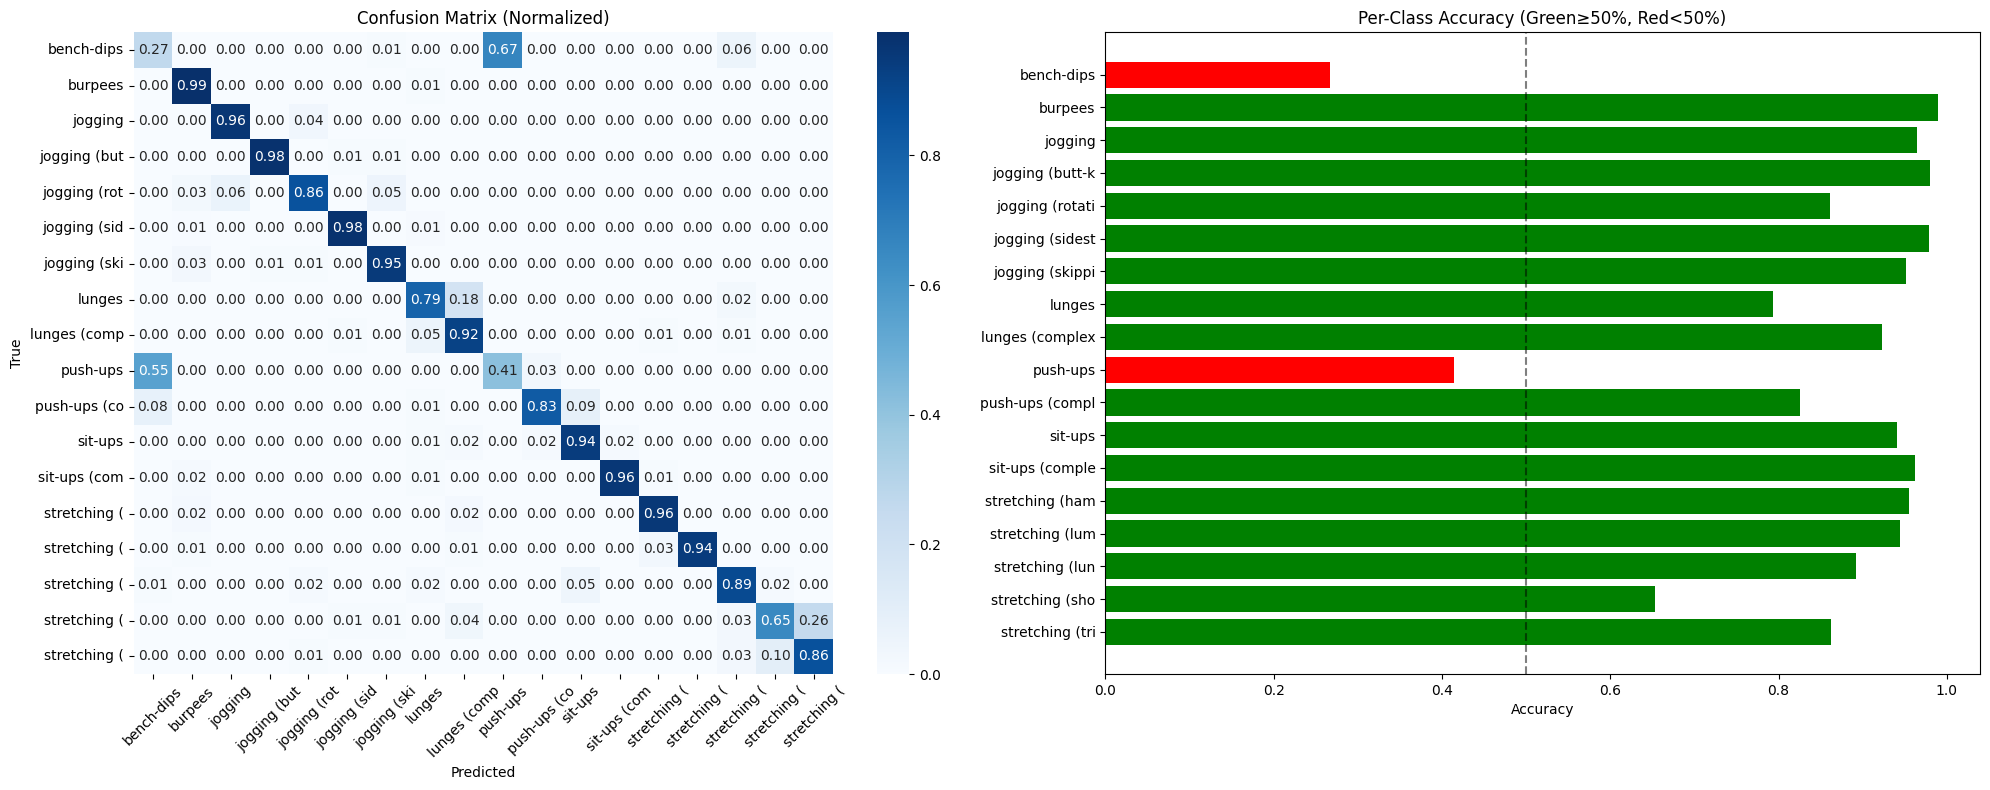


⚠️ Classes with low accuracy (<50%):
   bench-dips: 26.7%
   push-ups: 41.4%


In [14]:
# ============================================================
# CELL 12: CONFUSION MATRIX VISUALIZATION
# ============================================================
cm = confusion_matrix(y_test, y_test_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Confusion Matrix
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=axes[0],
            xticklabels=[decode_label[i][:12] for i in range(len(decode_label))],
            yticklabels=[decode_label[i][:12] for i in range(len(decode_label))])
axes[0].set_title('Confusion Matrix (Normalized)', fontsize=12)
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].tick_params(axis='x', rotation=45)

# Per-class accuracy bar chart
class_acc = np.diag(cm_normalized)
colors = ['green' if acc >= 0.5 else 'red' for acc in class_acc]
axes[1].barh(range(len(decode_label)), class_acc, color=colors)
axes[1].set_yticks(range(len(decode_label)))
axes[1].set_yticklabels([decode_label[i][:15] for i in range(len(decode_label))])
axes[1].set_xlabel('Accuracy')
axes[1].set_title('Per-Class Accuracy (Green≥50%, Red<50%)')
axes[1].axvline(x=0.5, color='black', linestyle='--', alpha=0.5)
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# Identify problematic classes
print("\n⚠️ Classes with low accuracy (<50%):")
for i in range(len(decode_label)):
    if class_acc[i] < 0.5:
        print(f"   {decode_label[i]}: {class_acc[i]*100:.1f}%")

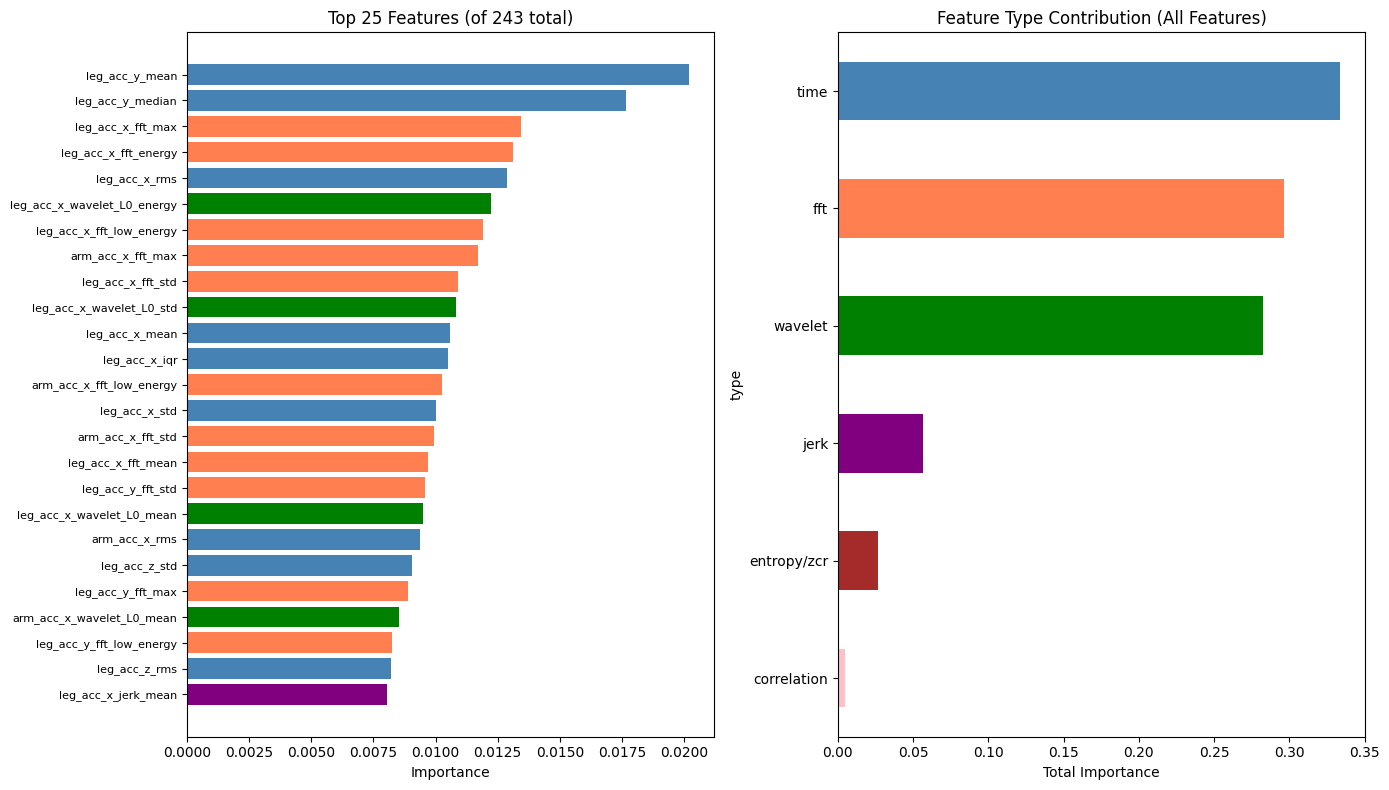


📊 Feature Type Contribution:
   correlation: 0.5%
   entropy/zcr: 2.6%
   jerk: 5.6%
   wavelet: 28.3%
   fft: 29.6%
   time: 33.4%


In [15]:
# ============================================================
# CELL 13: FEATURE IMPORTANCE (ALL Features)
# ============================================================
# Get feature importance from model
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# Categorize features
def get_feature_type(f):
    if 'wavelet' in f: return 'wavelet'
    elif 'fft' in f: return 'fft'
    elif 'jerk' in f: return 'jerk'
    elif 'entropy' in f or 'zcr' in f: return 'entropy/zcr'
    elif 'corr' in f: return 'correlation'
    else: return 'time'

feature_importance['type'] = feature_importance['feature'].apply(get_feature_type)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# Top 25 features
top_n = min(25, len(feature_importance))
top_feats = feature_importance.head(top_n)
type_colors = {'time': 'steelblue', 'fft': 'coral', 'wavelet': 'green', 
               'jerk': 'purple', 'entropy/zcr': 'brown', 'correlation': 'pink'}
colors = [type_colors.get(t, 'gray') for t in top_feats['type']]

axes[0].barh(range(top_n), top_feats['importance'].values, color=colors)
axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels(top_feats['feature'].values, fontsize=8)
axes[0].set_xlabel('Importance')
axes[0].set_title(f'Top {top_n} Features (of {len(feature_importance)} total)')
axes[0].invert_yaxis()

# Feature type contribution
type_importance = feature_importance.groupby('type')['importance'].sum().sort_values(ascending=True)
type_importance.plot(kind='barh', ax=axes[1], color=[type_colors.get(t, 'gray') for t in type_importance.index])
axes[1].set_xlabel('Total Importance')
axes[1].set_title('Feature Type Contribution (All Features)')

plt.tight_layout()
plt.show()

print("\n📊 Feature Type Contribution:")
for t, imp in type_importance.items():
    print(f"   {t}: {imp*100:.1f}%")